In [1]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [2]:
from collections import defaultdict
from typing import DefaultDict, List, Hashable, Dict, Any

from src.utils.utils import get_generator, get_project_root
from src.utils.test_result_store import TestResultStore

from src.pipeline.config import DataLoaderConfig, TaskLoaderConfig
from src.pipeline.taskloader import TaskLoader, TaskFrame
from src.pipeline.dataloader import DataLoader

from src.orchestrator.trainer import Trainer

from src.settings.tier import Tier
from src.settings.strategy import Strategy
from src.settings.metabolites import ENZYMES, METABOLITES, PRECURSOR_METABOLITES, PRECURSOR_METABOLITES_NO_TRANSFORM

from src.gnn.data_augmentation import DataAugmentation
from src.gnn.embeddings import generate_embedding
from src.gnn.graph_builder import get_samples_hetero_graph, get_graph_fc

import pandas as pd
import numpy as np

import cobra
from cobra.util import create_stoichiometric_matrix
from cobra.core import Reaction

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from more_itertools import flatten

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_absolute_error

from scipy.stats import pearsonr

import os
from functools import partial

from tqdm import tqdm

import torch
from torch.nn import BatchNorm1d, ModuleList
import torch.nn.functional as F

from torch_geometric.data import Data, HeteroData
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.loader import DataLoader as GeoDataLoader
from torch_geometric.nn import GAT, GCNConv, to_hetero, SAGEConv, GATConv, HeteroLinear, Linear, Node2Vec
import torch_geometric.transforms as T
from torch_geometric.nn.conv import HeteroConv

import mlflow.pytorch

from config import HYPERPARAMETERS, BEST_PARAMETERS

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler, FIFOScheduler
from ray.air import session, RunConfig
from ray.tune.integration.mlflow import mlflow_mixin
from ray.tune.integration.mlflow import MLflowLoggerCallback

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mlflow.set_tracking_uri("http://localhost:5000")
device = torch.device("cpu")
torch.manual_seed(42)

/home/tvangraft/tudelft/thesis/.env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = "/home/tvangraft/tudelft/thesis/metaengineering/data"
model = cobra.io.read_sbml_model(f'{path}/iMM904.xml')

In [4]:
edge_list_df_unfiltered = pd.read_csv('./data/training/edge_list_unfiltered.csv')
graph_fc_unfiltered = get_graph_fc(edge_list_df_unfiltered, PRECURSOR_METABOLITES_NO_TRANSFORM)
embedding_unfiltered = generate_embedding(graph_fc_unfiltered, edge_list_df_unfiltered, PRECURSOR_METABOLITES_NO_TRANSFORM, device)

edge_list_df_strict = pd.read_csv('./data/training/edge_list_strict.csv')
graph_fc_strict = get_graph_fc(edge_list_df_strict, PRECURSOR_METABOLITES)
embedding_strict = generate_embedding(graph_fc_strict, edge_list_df_strict, PRECURSOR_METABOLITES, device)

edge_list_df_all = pd.read_csv('./data/training/edge_list_all.csv')
graph_fc_all = get_graph_fc(edge_list_df_all, METABOLITES)
embedding_all = generate_embedding(graph_fc_all, edge_list_df_all, METABOLITES, device)

_metabolites_of_interest=['akg', 'e4p', 'accoa', 'f6p', 'pyr', 'oaa', 'r5p']
train set	 [13 29 17 51 15 38 73 71  7 65]
test set 	 [14 41 74 50  9  6 49 46 30 21]
val set  	 [28 11 61  2 59 10 54 18 43 52]
train mask 	 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
test mask  	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
val mask   	 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Epoch: 10, Loss: 2.1837
Epoch: 20, Loss: 1.6550
Epoch: 30, Loss: 1.4554
Epoch: 40, Loss: 1.2567
Epoch: 50, Loss: 1.0666
Epoch: 60, Loss: 0.9513
Epoch: 70, Loss: 0.8678
Epoch: 80, Loss: 0.8396
Epoch: 90, Loss: 0.8221
Epoch: 100, Loss: 0.7696
_metabolites_of_interest=['g6p;g6p-B', 'e4p', 'akg', 'pep', 'accoa', 'g6p;f6p;g6p-B', 'dhap', 'f6p', 'pyr', '3pg;2pg', 'oaa', 'r5p']
train set	 [53 86 67 21 22 73 84  4 47  2]
test set 	 [71 80 40 86 60 48 94 10 79 29]
val set  	 [37 33 85  3 61 44 13  9 26 27]
train mask 	 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
test mask  	 tensor([0,

# Modeling

## Model prep

In [5]:
def count_parameters(model):
    # for p in model.parameters():
    #     print(p)

    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def log_metrics(all_preds, all_ground_truth, all_knockout_ids, epoch, type: str, debug=False):
    mae = mean_absolute_error(all_ground_truth, all_preds)
    r2 = pearsonr(all_preds, all_ground_truth)[0]
    # all_knockout_ids = [data_augmentation_get_knockout_label(knockout_id) for knockout_id in all_knockout_ids]
    
    # k = np.array(X_test[X_test['metabolite_id'] == 'pyr']['KO_ORF'].unique())
    # mask_idx = np.argwhere(np.isin(all_knockout_ids, k)).flatten()
    # masked_mae = mean_absolute_error(all_ground_truth[mask_idx], all_preds[mask_idx])
    # masked_r2 = pearsonr(all_preds[mask_idx], all_ground_truth[mask_idx])[0]
    
    if debug:
        print(f"{mae=}")
        print(f"{r2=}")
    mlflow.log_metric(key="Mean absolute error", value=float(mae), step=epoch)
    mlflow.log_metric(key="R2 score", value=float(r2), step=epoch)
    # mlflow.log_metric(key="Masked Mean absolute error", value=float(masked_mae), step=epoch)
    # mlflow.log_metric(key="Masked R2 score", value=float(masked_r2), step=epoch)

In [6]:
def train_one_epoch(epoch, model, train_loader, optimizer, loss_fn):
    # Enumerate over the data
    running_loss = 0.0
    step = 0
    for _, batch in enumerate(train_loader):
        # Use GPU
        batch.to(device)
        # Reset gradients
        optimizer.zero_grad() 
        # Passing the node features and the connection info
        pred = model.forward(
            batch.x_dict, 
            batch.edge_index_dict,
        ) 
        # Calculating the loss and gradients
        train_mask = batch['metabolites'].train_mask.bool()
        loss = loss_fn(
            torch.squeeze(torch.nan_to_num(pred['metabolites'])), 
            torch.squeeze(torch.nan_to_num(batch['metabolites'].y.float()))
        )

        loss.backward()  
        optimizer.step()  
        # Update tracking
        running_loss += loss.item()
        step += 1
    
    # if epoch % 100 == 0:
    #     with tune.checkpoint_dir(epoch) as checkpoint_dir:
    #         path = os.path.join(checkpoint_dir, "checkpoint")
    #         torch.save((model.state_dict(), optimizer.state_dict()), path)

    tune.report(loss=(running_loss/step))

    return running_loss/step
    
@mlflow_mixin
def test(epoch, model, test_loader, loss_fn, debug=False):
    all_preds_raw = []
    all_labels = []
    all_knockout_ids = []
    running_loss = 0.0
    step = 0
    for batch in test_loader:
        batch.to(device)
        # print(batch)  
        pred = model(
            batch.x_dict, 
            batch.edge_index_dict,
        )
        test_mask = batch['metabolites'].test_mask.bool()

        if debug:
            print(f"{test_mask.sum()=}")
            print(
                f"{pred['metabolites'].shape=} \n"
                f"{pred['metabolites'][test_mask].mean()=} \n"
                f"{pred['metabolites'][test_mask].max()=} \n"
                f"{pred['metabolites'][test_mask].min()=} \n"
                f"{pred['metabolites'][test_mask].shape=} \n"
            ) 
        
        loss = loss_fn(
            torch.squeeze(torch.nan_to_num(pred['metabolites'][test_mask])), 
            torch.squeeze(torch.nan_to_num(batch['metabolites'].y.float()[test_mask]))
        )

         # Update tracking
        running_loss += loss.item()
        step += 1
        all_preds_raw.append(torch.nan_to_num(pred['metabolites'][test_mask]).cpu().detach().numpy())
        all_labels.append(torch.nan_to_num(batch['metabolites'].y[test_mask]).cpu().detach().numpy())
        # all_knockout_ids.append(batch['enzymes'].knockout_label_id.cpu().detach().numpy())
    
    all_preds_raw = np.concatenate(all_preds_raw).ravel()
    all_labels = np.concatenate(all_labels).ravel()
    # all_knockout_ids = np.concatenate(all_knockout_ids).ravel()
    log_metrics(all_preds_raw, all_labels, all_knockout_ids, epoch, "test")
    return running_loss/step

## Model construction

In [7]:
class HeteroGCNModel(torch.nn.Module):
    def __init__(self, model_config) -> None:
        super(HeteroGCNModel, self).__init__()
        embedding_size = model_config["model_embedding_size"]
        n_heads = model_config["model_attention_heads"]
        self.n_layers = model_config["model_layers"]
        
        self.conv_layers = ModuleList([])
        self.transf_layers = ModuleList([])
        self.pooling_layers = ModuleList([])
        self.bn_layers = ModuleList([])
        
        self.conv1 = GATConv(
            (-1, -1), out_channels=embedding_size, heads=n_heads, add_self_loops=False, bias=False
        )
        self.transf1 = Linear(
            in_channels=embedding_size*n_heads, 
            out_channels=embedding_size, 
        )

        for i in range(self.n_layers):
            self.conv_layers.append(
                GATConv(
                    (-1, -1), 
                    out_channels=embedding_size, 
                    heads=n_heads, 
                    add_self_loops=False
                )
            )
            self.transf_layers.append(
                Linear(
                    embedding_size*n_heads, 
                    embedding_size
                )
            )

        self.conv2 = GATConv(
            (-1, -1), out_channels=1, add_self_loops=False, bias=False
        )

        self.linear1 = Linear(n_heads * embedding_size, embedding_size)
        self.linear2 = Linear(embedding_size, 1)
    
    def forward(self, x, edge_index):
        # random weights for metabolite nodes should cancel out their contribution
        # metabolite_fc = torch.rand(x.shape[0], device=device)
        
        x = self.conv1(x, edge_index)
        # print(x)
        # x = torch.relu(self.transf1(x))

        for i in range(self.n_layers):
            x = self.conv_layers[i](x, edge_index)
            x = torch.relu(self.transf_layers[i](x))

        x = self.conv2(x, edge_index)
        
        # x = torch.relu(self.linear1(x))
        # x = F.dropout(x, p=0.8, training=self.training)
        # x = self.linear2(x)
        return x 

## Model running

In [8]:
@mlflow_mixin
def run_one_training(model_config, train_samples, test_samples, checkpoint_dir):
    print(f"creating model {model_config=}")
    params = model_config

    if 'mlflow' in model_config:
        run_id = model_config['mlflow']['tags']['mlflow.parentRunId']
        mlflow.set_tag("mlflow.parentRunId", run_id)
    # Logging params
    for key in params.keys():
        mlflow.log_param(key, params[key])

    # Preparing training
    train_loader = GeoDataLoader(train_samples, batch_size=params['batch_size'])
    test_loader = GeoDataLoader(test_samples, batch_size=1)
    
    # Loading the model
    print("Loading model...")
    model = HeteroGCNModel(model_config=params)
    model = to_hetero(model, train_samples[0].metadata(), aggr=params['aggr_strategy'])
    model = model.to(device)

    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    # < 1 increases precision, > 1 recall
    # loss_fn = torch.nn.MSELoss(reduction='none')
    loss_fn = torch.nn.MSELoss()
    # we need to keep the lr quite low since otherwise the weights explode
    optimizer = torch.optim.SGD(
        model.parameters(), 
        lr=params['learning_rate'],
        momentum=params['sgd_momentum'],
        # weight_decay=5e-4
    )
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params['scheduler_gamma'])
    
    # Start training
    best_loss = 1000
    early_stopping_counter = 0
    max_epochs = 300
    for epoch in tqdm(range(max_epochs)): 
        if early_stopping_counter <= 25: # = x * 5 
            # Training
            model.train()
            loss = train_one_epoch(epoch, model, train_loader, optimizer, loss_fn)
            # print(f"Epoch {epoch} | Train Loss {loss}")
            mlflow.log_metric(key="Train loss", value=float(loss), step=epoch)
            
            # Testing
            model.eval()
            if epoch % 5 == 0 or epoch == max_epochs - 1:
                loss = test(epoch, model, test_loader, loss_fn)
                # print(f"Epoch {epoch} | Test Loss {loss}")
                mlflow.log_metric(key="Test loss", value=float(loss), step=epoch)
                
                # Update best loss
                if float(loss) < best_loss:
                    best_loss = loss
                    # Save the currently best model 
                    # mlflow.pytorch.log_model(model, "model", signature=SIGNATURE)
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1

            scheduler.step()
            mlflow.log_metric(key="Learning rate", value=float(scheduler.get_last_lr()[0]), step=epoch)
            
        else:
            print("Early stopping due to no improvement.")
            session.report({
                "loss": best_loss
            })
            return {"loss": best_loss}
    print(f"Finishing training with best test loss: {best_loss}")

    with torch.no_grad():
        sample = train_samples[0].to(device)
        model.forward(sample.x_dict, sample.edge_index_dict)
        print(f"Number of parameters: {count_parameters(model)}")

    session.report({
        "loss": best_loss
    })

    mlflow.end_run()

    return {"loss": best_loss}

In [9]:
HYPERPARAMETERS = {
    "batch_size": tune.choice([2, 4, 8]),
    "learning_rate": tune.choice([0.1, 0.05, 0.01, 0.001]),
    "sgd_momentum": tune.choice([0.9, 0.8, 0.5]),
    "scheduler_gamma": tune.choice([0.995, 1]),
    "aggr_strategy": tune.choice(['mean', 'sum']),
    "model_embedding_size": tune.choice([8, 16, 32, 64, 128]),
    "model_attention_heads": tune.choice([1, 2, 3, 4]),
    "model_layers": tune.choice([1, 3, 5, 7]),
}

In [10]:
train_samples, test_samples = get_samples_hetero_graph(
    "pyr", Strategy.ALL, METABOLITES, graph_fc_all, edge_list_df_all, embedding_all)
print(len(train_samples))
print(len(test_samples))

print(f"{train_samples[0]['metabolites']['train_mask']=}")
print(f"{train_samples[0]['metabolites']['test_mask']=}")

print(f"{test_samples[0]['metabolites']['train_mask']=}")
print(f"{test_samples[0]['metabolites']['test_mask']=}")

66
29
train_samples[0]['metabolites']['train_mask']=tensor([1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0.])
train_samples[0]['metabolites']['test_mask']=tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
test_samples[0]['metabolites']['train_mask']=tensor([1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 0.])
test_samples[0]['metabolites']['test_mask']=tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0.])


In [11]:
def tune_metabolite_hyper_parameters(
    experiment_name,
    parameters,
    train_samples, 
    test_samples,
    num_samples=10,
    scheduler=None,
):

    parent_id = mlflow.active_run().info.run_id if mlflow.active_run() else None

    if scheduler is None:
        scheduler = ASHAScheduler(
            metric="loss",
            mode="min",
            max_t=300,
            grace_period=10,
            reduction_factor=2
        )
    reporter = CLIReporter(
        metric_columns=["loss", "training_iteration"]
    )

    trainable = tune.with_parameters(
        run_one_training, 
        train_samples=train_samples,
        test_samples=test_samples,
        checkpoint_dir=None,
    )

    result = tune.run(
        trainable,
        config={
            **parameters,
            "mlflow": {
                "experiment_name": experiment_name,
                "tracking_uri": mlflow.get_tracking_uri(),
                "save_artifacts": True,
                "tags": {
                    "mlflow.parentRunId": parent_id
                }
            }
        },
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter,
    )
    return result

# tune_metabolite_hyper_parameters("pyr")

In [12]:
def get_train_test_split(mode, metabolite_id, strategy):
    if mode == 'unfiltered':
        train_samples, test_samples = get_samples_hetero_graph(metabolite_id, strategy, PRECURSOR_METABOLITES_NO_TRANSFORM, graph_fc_unfiltered, edge_list_df_unfiltered, embedding_unfiltered)
    elif mode == 'strict':
        train_samples, test_samples = get_samples_hetero_graph(metabolite_id, strategy, PRECURSOR_METABOLITES, graph_fc_strict, edge_list_df_strict, embedding_strict)
    elif mode == 'all':
        train_samples, test_samples = get_samples_hetero_graph(metabolite_id, strategy, METABOLITES, graph_fc_all, edge_list_df_all, embedding_all)
    return train_samples, test_samples

In [ ]:
for strategy in [Strategy.ALL, Strategy.ONE_VS_ALL, Strategy.METABOLITE_CENTRIC]:
    for mode, graph_fc in [('unfiltered', graph_fc_unfiltered), ('strict', graph_fc_strict), ('all', graph_fc_all)]:
    # for mode, graph_fc in [('unfiltered', graph_fc_unfiltered)]:
        run_name = "model_gat_node_embeddings"
        experiment_name = f'metabolite_gnn_sweep_full_{mode}'
        mlflow.set_experiment(experiment_name)
        with mlflow.start_run(run_name=run_name) as run:
            for metabolite_id in list(set(graph_fc.columns.difference(ENZYMES).to_list()) & set(PRECURSOR_METABOLITES)):
                print(f"training {metabolite_id=}")
                train_samples, test_samples = get_train_test_split(mode, metabolite_id, strategy)

                with mlflow.start_run(run_name=f"model_{metabolite_id}_{strategy}", nested=True):
                    result = tune_metabolite_hyper_parameters(experiment_name, HYPERPARAMETERS, train_samples, test_samples, num_samples=16)
                    print(result)

# Fetch MLflow results

In [13]:
import mlflow
from mlflow.entities import ViewType, Run
from mlflow import MlflowClient

In [37]:
modes = ['unfiltered', 'strict', 'all']

experiments = []

for mode in modes:
    experiment_query = f"name = 'metabolite_gnn_sweep_full_{mode}'"
    experiments.append([exp.experiment_id for exp in mlflow.search_experiments(max_results=1, filter_string=experiment_query)][0])
print(experiments)

run_query = f"tags.mlflow.runName = 'model_gat_node_embeddings'"
newest_root_runs = mlflow.search_runs(experiment_ids=experiments, max_results=9, filter_string=run_query)['run_id'].values.tolist()
print(newest_root_runs)

['210903125578014489', '244231353501361589', '714823104100691740']
['f7d99c27ef69450aaf979a57c4e817af', '97540bf580d740c4b4f93620dfb9fc00', '2c076a98e3db48ddb55d409f085502f0', '7e5b10c78dc941f281abe2a7d6ec5d95', 'fdbd0e4ccd0d4edbb9710f68eba6f246', 'c7999998c3fd49bab5bce68a5fb96888', 'ad86695a5770452cb34c9a6e44bd3628', 'f63ebaf3a9e34f77a79daa942fbc1e8f', '7ec9dbfb50f243409425429bff0863fa']


In [ ]:
modes = ['all', 'strict', 'unfiltered']
experiments = []

for mode in modes:
    experiment_query = f"name = 'metabolite_gnn_sweep_full_{mode}'"
    experiments.append([exp.experiment_id for exp in mlflow.search_experiments(max_results=1, filter_string=experiment_query)][0])
print(f"{experiments=}")

modes = ['all', 'strict', 'unfiltered'] * 3

run_query = f"tags.mlflow.runName = 'model_gat_node_embeddings'"
newest_root_runs = mlflow.search_runs(experiment_ids=experiments, max_results=9, filter_string=run_query)['run_id'].values.tolist()
print(f"{newest_root_runs=}")
optimal_runs = []

for newest_root_run, mode in zip(newest_root_runs, modes):
    run_query = f"tags.mlflow.parentRunId = '{newest_root_run}'"
    metabolite_runs: List[Run] = mlflow.search_runs(experiment_ids=experiments, filter_string=run_query, output_format='list')

    for metabolite_run in metabolite_runs:
        run_name = metabolite_run.data.tags['mlflow.runName'].strip('model_')
        print(run_name)
        metabolite_id, strategy = run_name.split("_", 1)
        run_query = f"tags.mlflow.parentRunId = '{metabolite_run.info.run_id}'"
        runs = mlflow.search_runs(experiment_ids=experiments, filter_string=run_query)

        if 'metrics.R2 score' not in runs.columns:
            continue

        # print(runs)
        runs = runs.assign(
            metabolite_id=metabolite_id,
            mode=f"metabolite_gnn_sweep_full_{mode}",
            strategy=strategy
        ).fillna(0.0)
        optimal_runs.append(runs.loc[runs['metrics.R2 score'].idxmax()].to_frame())

result = pd.concat(optimal_runs, axis=1).T \
    .drop(
        ['experiment_id', 'status', 'artifact_uri', 'start_time', 'end_time', 'tags.mlflow.source.git.commit', 'tags.mlflow.source.type', 'tags.mlflow.user', 'params.mlflow', 'tags.mlflow.runName', 'tags.mlflow.parentRunId', 'tags.mlflow.source.name'], 
        axis=1
    )
result.to_csv('./data/validation/gnn_model_evaluation')
result

In [ ]:
result = pd.read_csv('./data/validation/gnn_model_evaluation')
result['metabolite_id'] = result['metabolite_id'].replace({'4p': 'e4p', 'hap': 'dhap', 'aa': 'oaa'})
result['metabolite_id'].unique()

filter_col = [col for col in result if col.startswith('params')]
result = result[result.groupby(['metabolite_id', 'mode', 'strategy'])['metrics.R2 score'].transform(max) == result['metrics.R2 score']]

# result = result.loc[result[['metabolite_id', 'mode']].drop_duplicates().index]
# result[filter_col].iloc[0].to_dict()
result.shape

def get_strategy(label):
    if label == 'Strategy.METABOLITE_CENTRIC':
        return Strategy.METABOLITE_CENTRIC
    elif label == 'Strategy.ONE_VS_ALL':
        return Strategy.ONE_VS_ALL
    elif label == 'Strategy.ALL':
        return Strategy.ALL

experiment_name = f'metabolite_gnn_retrain'
experiment_id = "553143683391760901"
mlflow.set_experiment(experiment_name)

scheduler = FIFOScheduler()

with mlflow.start_run(run_name='gnn_retrain') as run:
    for idx, row in result.iterrows():
        mode: str = row['mode'].replace('metabolite_gnn_sweep_full_', '')
        metabolite: str = row['metabolite_id']
        strategy = get_strategy(row['strategy'])
        model_params = { key.replace('params.', ''): value for key, value in row[filter_col].to_dict().items() }
        print(model_params)

        run_query = f"run_name = 'model_{mode}_{metabolite}_{strategy}'"
        if len(mlflow.search_runs(experiment_ids=[experiment_id], filter_string=run_query, output_format='list')) > 0:
            print(f"skipping: model_{mode}_{metabolite}_{strategy}")
            continue

        train_loader, test_loader = get_train_test_split(mode, metabolite, strategy)
        with mlflow.start_run(run_name=f"model_{mode}_{metabolite}_{strategy}", nested=True):
            result = tune_metabolite_hyper_parameters(
                experiment_name,
                model_params,
                train_loader, 
                test_loader, 
                num_samples=16,
                scheduler=scheduler, 
            )

        # break

    # print(row[filter_col].to_dict())

In [ ]:
run_query_first_halve = f"run_id = '7cfae7dad43343fe8d7a3a828dfdbba9'"
run_query_second_halve = f"run_id = 'b4a894cacc884d4fb018ec48c8974d84'"
experiment_id = "553143683391760901"

root_ids = ['7cfae7dad43343fe8d7a3a828dfdbba9', 'b4a894cacc884d4fb018ec48c8974d84']

results = []

for root_id in root_ids:
    run_query = f"tags.mlflow.parentRunId = '{root_id}'"
    rerun_configs: List[Run] = mlflow.search_runs(experiment_ids=experiment_id, filter_string=run_query, output_format='list')
    for rerun_config in rerun_configs:
        run_name: str = rerun_config.data.tags['mlflow.runName'].replace('model_', '')
        mode, metabolite_id, strategy = run_name.split("_", 2)
        print(f"{mode} {metabolite_id} {strategy}")
        
        run_query = f"tags.mlflow.parentRunId = '{rerun_config.info.run_id}'"
        runs: pd.DataFrame = mlflow.search_runs(experiment_ids=experiment_id, filter_string=run_query)

        runs = runs.assign(
            metabolite_id=metabolite_id,
            mode=mode,
            strategy=strategy
        ).fillna(0.0)

        results.append(runs)

results = pd.concat(results)
results.to_csv(f"./data/results/{Tier.TIER2}/gnn_model_retraining.csv")

In [32]:
import os

if not os.path.exists(f"./data/results/{Tier.TIER2}/"):
    os.makedirs(f"./data/results/{Tier.TIER2}/")

results.to_csv(f"./data/results/{Tier.TIER2}/gnn_model_retraining.csv")


import seaborn as sns

In [59]:
results.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metabolite_id', 'mode', 'strategy', 'metrics.Train loss',
       'metrics.Test loss', 'metrics.R2 score', 'metrics.Learning rate',
       'metrics.Mean absolute error', 'params.model_layers',
       'params.learning_rate', 'params.model_embedding_size',
       'params.model_attention_heads', 'params.scheduler_gamma',
       'params.mlflow', 'params.batch_size', 'params.sgd_momentum',
       'params.aggr_strategy', 'tags.mlflow.runName',
       'tags.mlflow.parentRunId', 'tags.mlflow.user',
       'tags.mlflow.source.git.commit', 'tags.mlflow.source.name',
       'tags.mlflow.source.type'],
      dtype='object')

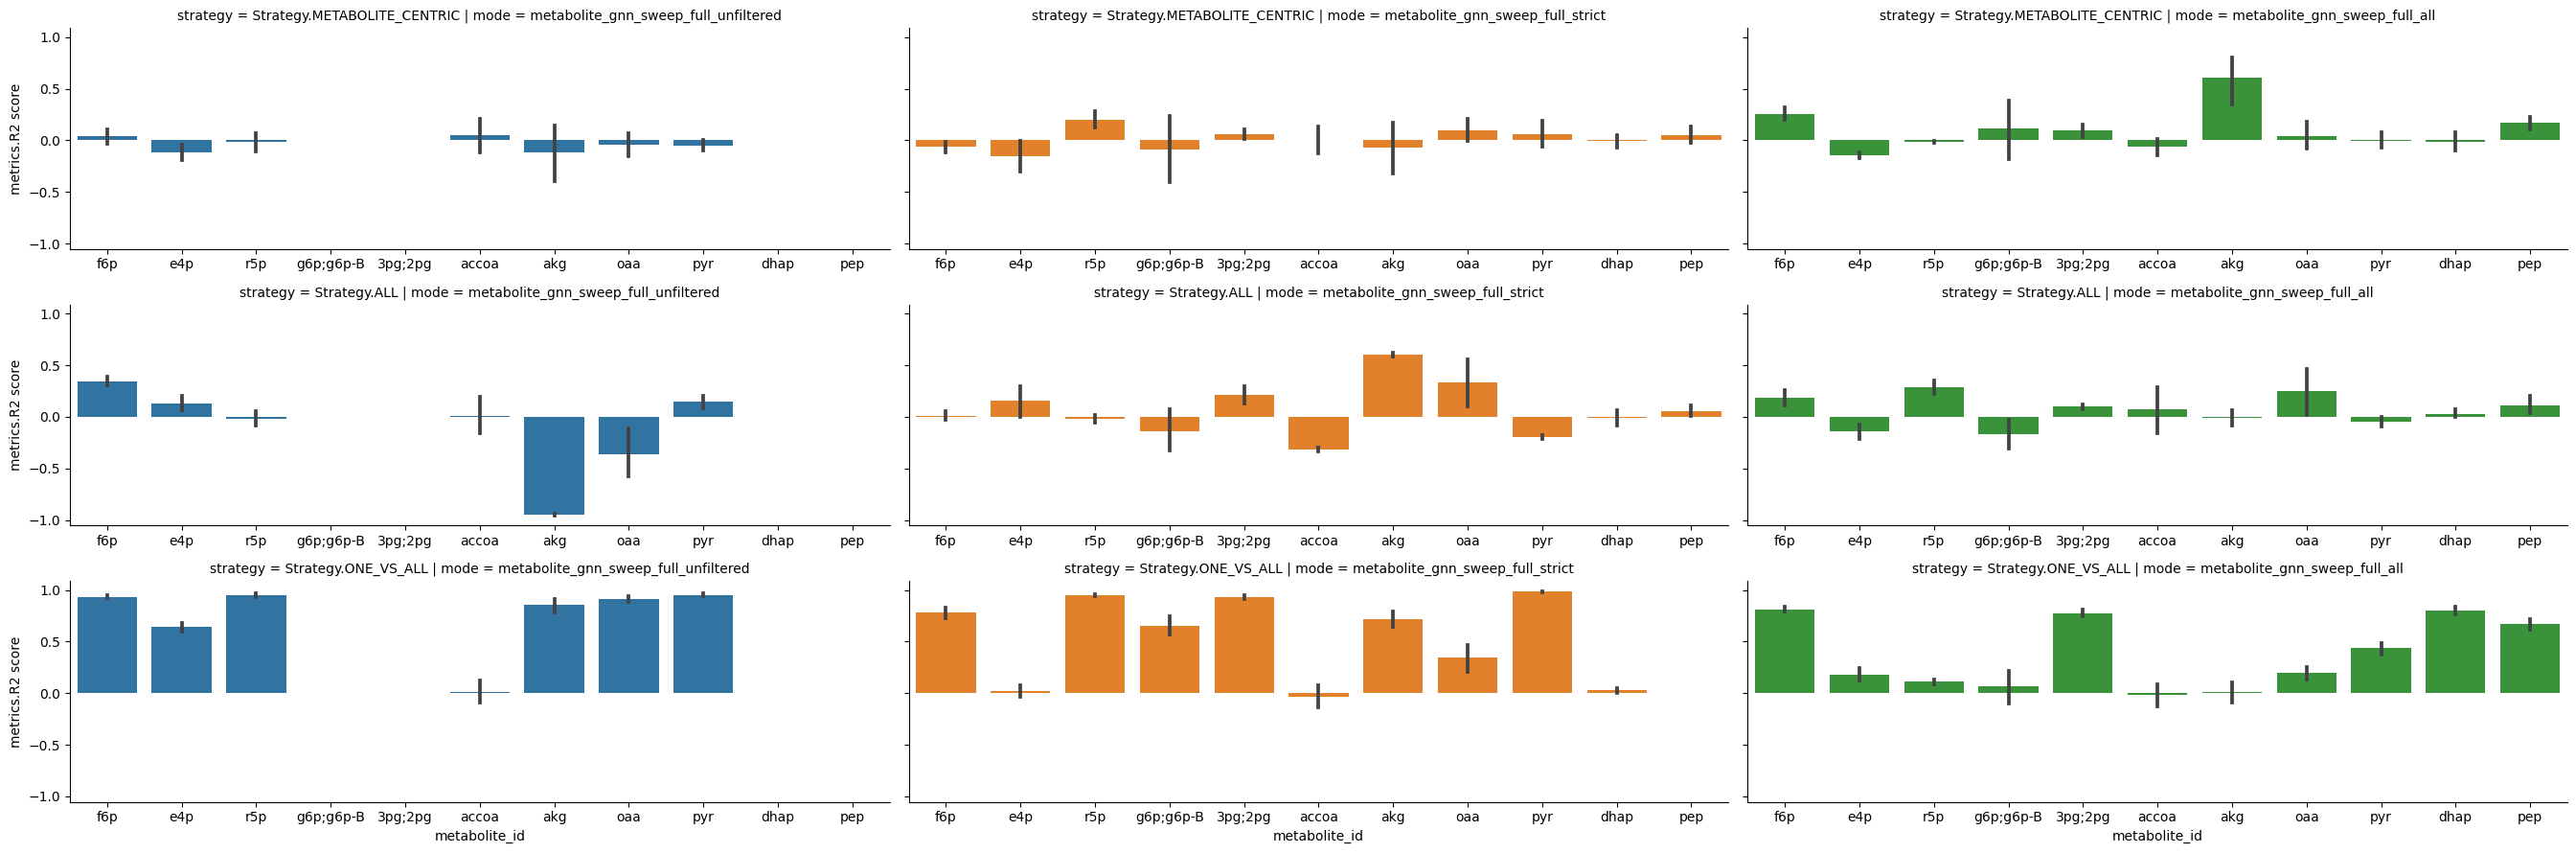

In [60]:
# fig, ax = plt.subplots(1,1, figsize=(32, 32))
results.to_csv(f"./data/results/{Tier.TIER2}/gnn_model_retraining.csv")
g = sns.FacetGrid(
    data=results,
    col='mode',
    row='strategy',
    hue='mode',
    sharex=False,
    sharey=True,
    aspect=3,
    hue_order=[
        'metabolite_gnn_sweep_full_unfiltered',
        'metabolite_gnn_sweep_full_strict',
        'metabolite_gnn_sweep_full_all',
    ],
    row_order=[
        'Strategy.METABOLITE_CENTRIC',
        'Strategy.ALL',
        'Strategy.ONE_VS_ALL', 
    ],
    col_order=[
        'metabolite_gnn_sweep_full_unfiltered',
        'metabolite_gnn_sweep_full_strict',
        'metabolite_gnn_sweep_full_all',
    ]
)
g.map(sns.barplot, 'metabolite_id', 'metrics.R2 score', order=['f6p', 'e4p', 'r5p', 'g6p;g6p-B', '3pg;2pg', 'accoa', 'akg', 'oaa', 'pyr', 'dhap', 'pep'])